In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

In [ ]:
import os.path as osp
from math import ceil

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, DenseGraphConv, dense_mincut_pool
from torch_geometric.utils import to_dense_batch, to_dense_adj

In [ ]:
# @title mincut pool

EPS = 1e-15

def dense_mincut_pool(x, adj, s, mask=None):
    r"""MinCUt pooling operator from the `"Mincut Pooling in Graph Neural
    Networks" <https://arxiv.org/abs/1907.00481>`_ paper

    .. math::
        \mathbf{X}^{\prime} &= {\mathrm{softmax}(\mathbf{S})}^{\top} \cdot
        \mathbf{X}

        \mathbf{A}^{\prime} &= {\mathrm{softmax}(\mathbf{S})}^{\top} \cdot
        \mathbf{A} \cdot \mathrm{softmax}(\mathbf{S})

    based on dense learned assignments :math:`\mathbf{S} \in \mathbb{R}^{B
    \times N \times C}`.
    Returns pooled node feature matrix, coarsened symmetrically normalized
    adjacency matrix and two auxiliary objectives: (1) The minCUT loss

    .. math::
        \mathcal{L}_c = - \frac{\mathrm{Tr}(\mathbf{S}^{\top} \mathbf{A}
        \mathbf{S})} {\mathrm{Tr}(\mathbf{S}^{\top} \mathbf{D}
        \mathbf{S})}

    where :math:`\mathbf{D}` is the degree matrix, and (2) the orthogonality
    loss

    .. math::
        \mathcal{L}_o = {\left\| \frac{\mathbf{S}^{\top} \mathbf{S}}
        {{\|\mathbf{S}^{\top} \mathbf{S}\|}_F} -\frac{\mathbf{I}_C}{\sqrt{C}}
        \right\|}_F.

    Args:
        x (Tensor): Node feature tensor :math:`\mathbf{X} \in \mathbb{R}^{B
            \times N \times F}` with batch-size :math:`B`, (maximum)
            number of nodes :math:`N` for each graph, and feature dimension
            :math:`F`.
        adj (Tensor): Symmetrically normalized adjacency tensor
            :math:`\mathbf{A} \in \mathbb{R}^{B \times N \times N}`.
        s (Tensor): Assignment tensor :math:`\mathbf{S} \in \mathbb{R}^{B
            \times N \times C}` with number of clusters :math:`C`. The softmax
            does not have to be applied beforehand, since it is executed
            within this method.
        mask (BoolTensor, optional): Mask matrix
            :math:`\mathbf{M} \in {\{ 0, 1 \}}^{B \times N}` indicating
            the valid nodes for each graph. (default: :obj:`None`)

    :rtype: (:class:`Tensor`, :class:`Tensor`, :class:`Tensor`,
        :class:`Tensor`)
    """

    x = x.unsqueeze(0) if x.dim() == 2 else x
    adj = adj.unsqueeze(0) if adj.dim() == 2 else adj
    s = s.unsqueeze(0) if s.dim() == 2 else s

    (batch_size, num_nodes, _), k = x.size(), s.size(-1)

    s = torch.softmax(s, dim=-1)

    if mask is not None:
        mask = mask.view(batch_size, num_nodes, 1).to(x.dtype)
        x, s = x * mask, s * mask

    out = torch.matmul(s.transpose(1, 2), x)
    out_adj = torch.matmul(torch.matmul(s.transpose(1, 2), adj), s)

    # MinCUT regularization.
    mincut_num = _rank3_trace(out_adj)
    d_flat = torch.einsum('ijk->ij', adj)
    d = _rank3_diag(d_flat)
    mincut_den = _rank3_trace(
        torch.matmul(torch.matmul(s.transpose(1, 2), d), s))
    mincut_loss = -(mincut_num / mincut_den)
    mincut_loss = torch.mean(mincut_loss)

    # Orthogonality regularization.
    ss = torch.matmul(s.transpose(1, 2), s)
    i_s = torch.eye(k).type_as(ss)
    ortho_loss = torch.norm(
        ss / torch.norm(ss, dim=(-1, -2), keepdim=True) -
        i_s / torch.norm(i_s), dim=(-1, -2))
    ortho_loss = torch.mean(ortho_loss)

    # Fix and normalize coarsened adjacency matrix.
    ind = torch.arange(k, device=out_adj.device)
    out_adj[:, ind, ind] = 0
    d = torch.einsum('ijk->ij', out_adj)
    d = torch.sqrt(d)[:, None] + EPS
    out_adj = (out_adj / d) / d.transpose(1, 2)

    return out, out_adj, mincut_loss, ortho_loss



def _rank3_trace(x):
    return torch.einsum('ijj->i', x)


def _rank3_diag(x):
    eye = torch.eye(x.size(1)).type_as(x)
    out = eye * x.unsqueeze(2).expand(*x.size(), x.size(1))
    return out

#### Spectral graph coarsening for GCNNs

$$
\begin{align}
X &= \textrm{GNN}(X, A; \Theta_\textrm{GNN}) \\
S &= \textrm{MLP}(X; \Theta_\textrm{MLP})
\end{align}
$$

$$
\begin{align}
\mathcal{L}_u &= \mathcal{L}_c + \mathcal{L}_o \\
&= -\frac{Tr(S^TAS)}{Tr(S^TDS)} + \big\lvert\big\lvert\frac{S^TS}{||S^TS||_F} - \frac{I_K}{\sqrt{K}}\big\rvert\big\rvert_F
\end{align}
$$

The coarsened adjacency matrix and pooled vertex features are then computed:
$$
\hat{A} = S^TAS;\quad \hat{X}=S^TX
$$

#### Label-aware spectral graph coarsening for GCNNs

Idea: add group-sparse regularization on the columns of $S$.

In [ ]:
# @title label-aware mincut pool

EPS = 1e-15

def dense_la_mincut_pool(x, groups, adj, s, mask=None):
    r"""MinCUt pooling operator from the `"Mincut Pooling in Graph Neural
    Networks" <https://arxiv.org/abs/1907.00481>`_ paper

    .. math::
        \mathbf{X}^{\prime} &= {\mathrm{softmax}(\mathbf{S})}^{\top} \cdot
        \mathbf{X}

        \mathbf{A}^{\prime} &= {\mathrm{softmax}(\mathbf{S})}^{\top} \cdot
        \mathbf{A} \cdot \mathrm{softmax}(\mathbf{S})

    based on dense learned assignments :math:`\mathbf{S} \in \mathbb{R}^{B
    \times N \times C}`.
    Returns pooled node feature matrix, coarsened symmetrically normalized
    adjacency matrix and two auxiliary objectives: (1) The minCUT loss

    .. math::
        \mathcal{L}_c = - \frac{\mathrm{Tr}(\mathbf{S}^{\top} \mathbf{A}
        \mathbf{S})} {\mathrm{Tr}(\mathbf{S}^{\top} \mathbf{D}
        \mathbf{S})}

    where :math:`\mathbf{D}` is the degree matrix, and (2) the orthogonality
    loss

    .. math::
        \mathcal{L}_o = {\left\| \frac{\mathbf{S}^{\top} \mathbf{S}}
        {{\|\mathbf{S}^{\top} \mathbf{S}\|}_F} -\frac{\mathbf{I}_C}{\sqrt{C}}
        \right\|}_F.

    Args:
        x (Tensor): Node feature tensor :math:`\mathbf{X} \in \mathbb{R}^{B
            \times N \times F}` with batch-size :math:`B`, (maximum)
            number of nodes :math:`N` for each graph, and feature dimension
            :math:`F`.
        adj (Tensor): Symmetrically normalized adjacency tensor
            :math:`\mathbf{A} \in \mathbb{R}^{B \times N \times N}`.
        s (Tensor): Assignment tensor :math:`\mathbf{S} \in \mathbb{R}^{B
            \times N \times C}` with number of clusters :math:`C`. The softmax
            does not have to be applied beforehand, since it is executed
            within this method.
        mask (BoolTensor, optional): Mask matrix
            :math:`\mathbf{M} \in {\{ 0, 1 \}}^{B \times N}` indicating
            the valid nodes for each graph. (default: :obj:`None`)

    :rtype: (:class:`Tensor`, :class:`Tensor`, :class:`Tensor`,
        :class:`Tensor`)
    """
    x = x.unsqueeze(0) if x.dim() == 2 else x
    adj = adj.unsqueeze(0) if adj.dim() == 2 else adj
    s = s.unsqueeze(0) if s.dim() == 2 else s
    groups = groups.unsqueeze(0) if groups.dim() == 2 else groups

    (batch_size, num_nodes, _), k = x.size(), s.size(-1)

    s = torch.softmax(s, dim=-1)

    if mask is not None:
        mask = mask.view(batch_size, num_nodes, 1).to(x.dtype)
        x, s, groups = x * mask, s * mask, groups * mask

    out = torch.matmul(s.transpose(1, 2), x)
    out_adj = torch.matmul(torch.matmul(s.transpose(1, 2), adj), s)

    # Soft label-group sparsity regularization
    group_loss = 0
    for group in groups.reshape(batch_size*num_nodes,-1).unique(dim=0):
      for batch_group, smat in zip(groups, s):
        group_loss += torch.sum(torch.norm(smat[(batch_group==group).all(dim=1)],p=2,dim=0))/batch_size

    # MinCUT regularization.
    mincut_num = _rank3_trace(out_adj)
    d_flat = torch.einsum('ijk->ij', adj)
    d = _rank3_diag(d_flat)
    mincut_den = _rank3_trace(
        torch.matmul(torch.matmul(s.transpose(1, 2), d), s))
    mincut_loss = -(mincut_num / mincut_den)
    mincut_loss = torch.mean(mincut_loss)

    # Orthogonality regularization.
    ss = torch.matmul(s.transpose(1, 2), s)
    i_s = torch.eye(k).type_as(ss)
    ortho_loss = torch.norm(
        ss / torch.norm(ss, dim=(-1, -2), keepdim=True) -
        i_s / torch.norm(i_s), dim=(-1, -2))
    ortho_loss = torch.mean(ortho_loss)

    # Fix and normalize coarsened adjacency matrix.
    ind = torch.arange(k, device=out_adj.device)
    out_adj[:, ind, ind] = 0
    d = torch.einsum('ijk->ij', out_adj)
    d = torch.sqrt(d)[:, None] + EPS
    out_adj = (out_adj / d) / d.transpose(1, 2)

    return out, out_adj, mincut_loss, ortho_loss,  group_loss

In [ ]:
path = osp.join(osp.dirname(osp.realpath('./')), '..', 'data', 'ENZYMES')
torch.manual_seed(2)
dataset = TUDataset(path, name='ENZYMES', use_node_attr=True).shuffle()
average_nodes = int(dataset.data.x.size(0) / len(dataset))
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
test_loader = DataLoader(test_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

In [ ]:
for t in test_loader:
  print(t.num_node_features, dataset.num_node_attributes, t.x.shape, t.y.shape)
  break

21 18 torch.Size([1984, 21]) torch.Size([60])


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32):
        super(Net, self).__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        num_nodes = ceil(0.5 * average_nodes)
        self.pool1 = Linear(hidden_channels, num_nodes)

        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        num_nodes = ceil(0.5 * num_nodes)
        self.pool2 = Linear(hidden_channels, num_nodes)

        self.conv3 = DenseGraphConv(hidden_channels, hidden_channels)

        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, groups, edge_index, batch):

        x = F.relu(self.conv1(x, edge_index))
        x, mask = to_dense_batch(x, batch)
        adj = to_dense_adj(edge_index, batch)

        groups, _ = to_dense_batch(groups, batch)

        s = self.pool1(x)
        #x, adj, mc1, o1 = dense_mincut_pool(x, adj, s, mask)
        #g1 = 0
        x, adj, mc1, o1, g1 = dense_la_mincut_pool(x, groups, adj, s, mask)

        x = F.relu(self.conv2(x, adj))
        #s = self.pool2(x)

        #x, adj, mc2, o2 = dense_mincut_pool(x, adj, s)
        #x = self.conv3(x, adj)
        x = x.mean(dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), mc1, o1, g1


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_node_attributes, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
def train(epoch, reg_weight=0.05):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, mc_loss, o_loss, g_loss = model(data.x[:,:dataset.num_node_attributes], data.x[:,dataset.num_node_attributes:], data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y.view(-1)) + mc_loss + o_loss + reg_weight*g_loss
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)

In [ ]:
@torch.no_grad()
def test(loader, reg_weight=0.05):
    model.eval()
    correct = 0
    loss_all = 0

    for data in loader:
        data = data.to(device)
        pred, mc_loss, o_loss , g_loss= model(data.x[:,:dataset.num_node_attributes], data.x[:,dataset.num_node_attributes:], data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss + reg_weight*g_loss
        loss_all += data.y.size(0) * loss.item()
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss_all / len(loader.dataset), correct / len(loader.dataset)

In [ ]:
best_val_acc = test_acc = 0
best_val_loss = float('inf')
patience = start_patience = 100

reg_weight = 0.2

test_acs = []
bsf_test_acs = []
val_acs = []
tr_acs = []
for epoch in range(1, 501):
    train_loss = train(epoch, reg_weight)
    _, train_acc = test(train_loader, reg_weight)
    val_loss, val_acc = test(val_loader, reg_weight)
    test_loss, test_acc = test(test_loader, reg_weight)
    if val_loss < best_val_loss:
        es_test_loss, es_test_acc = test(test_loader, reg_weight)
        best_val_acc = val_acc
        best_val_loss = val_loss
        patience = start_patience
    #else:
    #    patience -= 1
    #    if patience == 0:
    #        break
    bsf_test_acs.append(es_test_acc)
    print('Epoch: {:03d}, '
          'Train Loss: {:.3f}, Train Acc: {:.3f}, '
          'Val Loss: {:.3f}, Val Acc: {:.3f}, '
          'Test Loss: {:.3f}, Test Acc: {:.3f}, Early Stop Test Acc: {:.3f}'.format(epoch, train_loss,
                                                       train_acc, val_loss,
                                                       val_acc, test_loss,
                                                       test_acc, es_test_acc))
    test_acs.append(test_acc)
    val_acs.append(val_acc)
    tr_acs.append(train_acc)

Epoch: 001, Train Loss: 4.450, Train Acc: 0.181, Val Loss: 3.933, Val Acc: 0.150, Test Loss: 4.223, Test Acc: 0.167, Early Stop Test Acc: 0.167
Epoch: 002, Train Loss: 3.822, Train Acc: 0.190, Val Loss: 3.801, Val Acc: 0.083, Test Loss: 3.800, Test Acc: 0.150, Early Stop Test Acc: 0.150
Epoch: 003, Train Loss: 3.727, Train Acc: 0.242, Val Loss: 3.803, Val Acc: 0.117, Test Loss: 3.789, Test Acc: 0.217, Early Stop Test Acc: 0.150
Epoch: 004, Train Loss: 3.684, Train Acc: 0.244, Val Loss: 3.754, Val Acc: 0.300, Test Loss: 3.772, Test Acc: 0.217, Early Stop Test Acc: 0.217
Epoch: 005, Train Loss: 3.623, Train Acc: 0.229, Val Loss: 3.661, Val Acc: 0.167, Test Loss: 3.704, Test Acc: 0.150, Early Stop Test Acc: 0.150
Epoch: 006, Train Loss: 3.588, Train Acc: 0.217, Val Loss: 3.636, Val Acc: 0.167, Test Loss: 3.665, Test Acc: 0.167, Early Stop Test Acc: 0.167
Epoch: 007, Train Loss: 3.587, Train Acc: 0.244, Val Loss: 3.600, Val Acc: 0.267, Test Loss: 3.668, Test Acc: 0.233, Early Stop Test Acc

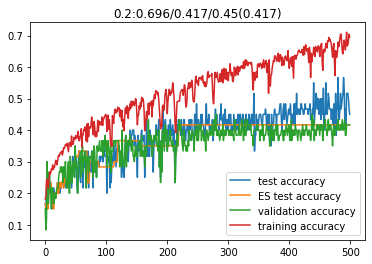

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_acs, label='test accuracy')
plt.plot(bsf_test_acs, label='ES test accuracy')
plt.plot(val_acs, label='validation accuracy')
plt.plot(tr_acs, label='training accuracy')
plt.title('{}:{}/{}/{}({})'.format(reg_weight, round(tr_acs[-1],3),round(val_acs[-1],3),round(test_acs[-1],3),round(bsf_test_acs[-1],3)))
plt.legend()

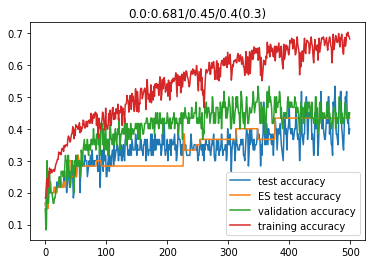

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_acs, label='test accuracy')
plt.plot(bsf_test_acs, label='ES test accuracy')
plt.plot(val_acs, label='validation accuracy')
plt.plot(tr_acs, label='training accuracy')
plt.title('{}:{}/{}/{}({})'.format(reg_weight, round(tr_acs[-1],3),round(val_acs[-1],3),round(test_acs[-1],3),round(bsf_test_accs[-1],3)))
plt.legend()